PCA uses linear transfomation to reduce the dimensions of our dataset. And as a bonus, because PCA transforms the data by exploring ‘linear’ covariances between the variables it can also be used as an anomaly detector. Because any recipe that doesn’t follow the ‘structure’ of the initial dataset, won’t transform well.

6714 ingredients -> 6714 columns. When one ingredient is present in a recipe, its column goes to 1. All the rest stays as a 0. In average only 10 of those columns will be ‘active’ in each row based on statistics outlined below. This code will create the “transformer”, that will get an ingredient and output its vector representation. Following code gives us an encoder that will get a ingredient (string) as input and output its vector representation. The final vector containing all the recipe’s ingredients will be the result of a ‘logical or’ on every one of those ingredient vectors. We are only exploring ONE-HOT-ENCODING(ohe) and Continoeus-Bag-Of-Words(cbow) encodings.

Total number of recipes: 39774
Number of cuisines: 20
Cuisine count map: 

        italian: 7838
        mexican: 6438
    southern_us: 4320
         indian: 3003
        chinese: 2673
         french: 2646
   cajun_creole: 1546
           thai: 1539
       japanese: 1423
          greek: 1175
        spanish: 989
         korean: 830
     vietnamese: 825
       moroccan: 821
        british: 804
       filipino: 755
          irish: 667
       jamaican: 526
        russian: 489
      brazilian: 467


Number of ingredients: 6714
Ingredient count map: 

                     salt: 18049
                   onions: 7972
                olive oil: 7972
                    water: 7457
                   garlic: 7380
                    sugar: 6434
            garlic cloves: 6237
                   butter: 4848
      ground black pepper: 4785
        all-purpose flour: 4632
                   pepper: 4438
            vegetable oil: 4385
                     eggs: 3388
                soy sauc

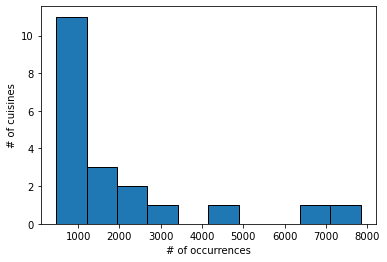

Summary statistics of above graph
            series
count    20.000000
mean   1988.700000
std    2041.558772
min     467.000000
25%     791.750000
50%    1082.000000
75%    2652.750000
max    7838.000000


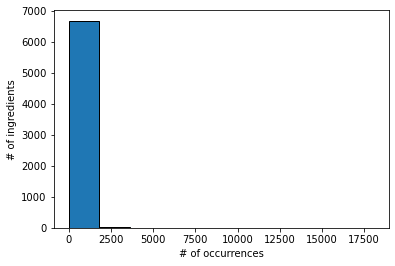

Summary statistics of above graph
             series
count   6714.000000
mean      63.788353
std      388.355948
min        1.000000
25%        1.000000
50%        4.000000
75%       20.000000
max    18049.000000
Average number of ingredients per recipe: 10.76771257605471
Std. dev. number of ingredients per recipe: 4.428921893064523


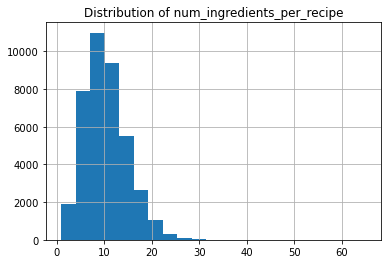

In [1]:
# Let us do the training set first
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
%matplotlib inline

cuisines = set()
ingredients = set()
cuisine_count_map = {}
ingredient_count_map = {}
num_ingredients_per_recipe = []

# helper func to flatten dict into df
def show_hist_of_dict(count_map, y_label, x_label):
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.hist(count_map.values(), ec='black')
    plt.show()    
    # print summary statistics
    print('Summary statistics of above graph')
    series = {'series': pd.Series(count_map.values())}
    data_frame = pd.DataFrame(series)
    print(data_frame.describe())


with open('./train.json', 'r') as file:
    data = json.load(file)    
    # print number of recipes, recipes could contain duplicated cuisines
    print('Total number of recipes: {}'.format(len(data)))    
    for recipe in data:    
        # stats on number of cuisines, remove duplicates by adding them to a set
        cuisines.add(recipe['cuisine'])
        if recipe['cuisine'] not in cuisine_count_map:
            cuisine_count_map[recipe['cuisine']] = 0
        cuisine_count_map[recipe['cuisine']] += 1           
        # stats on number of ingredients, remove duplicate ingredients by add them to set
        num_ingredients_per_recipe.append(len(recipe['ingredients']))
        for ingredient in recipe['ingredients']:
            ingredients.add(ingredient)            
            if ingredient not in ingredient_count_map:
                ingredient_count_map[ingredient] = 0
            ingredient_count_map[ingredient] += 1    
    print('Number of cuisines: {}'.format(len(cuisines)))
    print('Cuisine count map: \n')
    cuisine_count_map = dict(sorted(cuisine_count_map.items(), key=lambda item: item[1], reverse=True))
    for cuisine in cuisine_count_map:
        print('{:>15}: {}'.format(cuisine, cuisine_count_map[cuisine]))
    print('\n')
    print('Number of ingredients: {}'.format(len(ingredients)))
    print('Ingredient count map: \n')
    ingredient_count_map = dict(sorted(ingredient_count_map.items(), key=lambda item: item[1], reverse=True))
    for ingredient in ingredient_count_map:
        print('{:>25}: {}'.format(ingredient, ingredient_count_map[ingredient]))
    print('\n')
    # show histogram of ingredients and cuisines
    show_hist_of_dict(cuisine_count_map, '# of cuisines', '# of occurrences')
    show_hist_of_dict(ingredient_count_map, '# of ingredients', '# of occurrences')
    # print average number of ingredients per recipe
    print('Average number of ingredients per recipe: {}'.format(np.mean(num_ingredients_per_recipe)))
    print('Std. dev. number of ingredients per recipe: {}'.format(np.std(num_ingredients_per_recipe)))
    # AMOUNT column data distribution histgram density plot    
    series = {'series': pd.Series(num_ingredients_per_recipe)}
    data_frame = pd.DataFrame(series)
    data_frame.hist(bins=21)
    plt.title("Distribution of num_ingredients_per_recipe")
    plt.show() 

Total number of recipes: 9944
Number of ingredients: 4484
Test ingredient count map: 

                               salt: 4485
                             onions: 2036
                          olive oil: 1917
                              water: 1836
                             garlic: 1791
                              sugar: 1630
                      garlic cloves: 1535
                             butter: 1230
                ground black pepper: 1205
                  all-purpose flour: 1184
                      vegetable oil: 1131
                             pepper: 1070
                               eggs: 874
                          soy sauce: 824
                        kosher salt: 817
                           tomatoes: 754
                         large eggs: 752
                       green onions: 739
                            carrots: 728
                    unsalted butter: 692
                       ground cumin: 684
             extra-virgin olive oil: 677

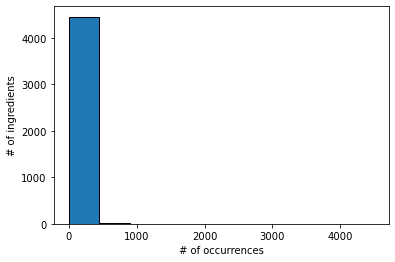

Summary statistics of above graph
            series
count  4484.000000
mean     23.950714
std     117.785328
min       1.000000
25%       1.000000
50%       3.000000
75%      11.000000
max    4485.000000
Statistics on number of ingredients per recipe:
Average number of ingredients per recipe: 10.799979887369268
Std. dev. number of ingredients per recipe: 4.466929073709953
            series
count  9944.000000
mean     10.799980
std       4.467154
min       1.000000
25%       8.000000
50%      10.000000
75%      13.000000
max      50.000000


In [2]:
# Test data
test_ingredients = set()
test_ingredient_count_map = {}
test_num_ingredients_per_recipe = []

with open('./test.json', 'r') as file:
    data = json.load(file)    
    # print number of recipes
    print('Total number of recipes: {}'.format(len(data)))    
    for recipe in data:            
        # stats on number of ingredients
        test_num_ingredients_per_recipe.append(len(recipe['ingredients']))
        for ingredient in recipe['ingredients']:
            test_ingredients.add(ingredient)            
            if ingredient not in test_ingredient_count_map:
                test_ingredient_count_map[ingredient] = 0
            test_ingredient_count_map[ingredient] += 1    
    print('Number of ingredients: {}'.format(len(test_ingredients)))
    print('Test ingredient count map: \n')
    test_ingredient_count_map = dict(sorted(test_ingredient_count_map.items(), key=lambda item: item[1], reverse=True))
    for ingredient in test_ingredient_count_map:
        print('{:>35}: {}'.format(ingredient, test_ingredient_count_map[ingredient]))
    print('\n')    
    # show histogram of ingredients and cuisines
    show_hist_of_dict(test_ingredient_count_map, '# of ingredients', '# of occurrences')    
    # print average number of ingredients per recipe
    print('Statistics on number of ingredients per recipe:')
    print('Average number of ingredients per recipe: {}'.format(np.mean(test_num_ingredients_per_recipe)))
    print('Std. dev. number of ingredients per recipe: {}'.format(np.std(test_num_ingredients_per_recipe)))
    series = {'series': pd.Series(test_num_ingredients_per_recipe)}
    data_frame = pd.DataFrame(series)
    print(data_frame.describe())

Principal Component Analysis and Preliminary Model
Because of the curse of dimensionality, training a model on this vector space will take way too long. For this we first use a linear dimensionality reduction tool PCA Now that we have seen how something like PCA can make sense of the data, we come to the interesting part which is to try to find a better vector representation of the words in a recipe

The implementation of this model is to use an autoencoder architecture where the One-Hot encoded word vectors are used in the model as inputs and encoded into the learnt representations and then the decoder will try to recreate the target word.

In [3]:
# helper functions
# returns most common element in a list
def most_common(lst):
    return max(set(lst), key=lst.count)
# function to plot confusion matrix
def show_confusion_matrix(y_predicted, y_true, label_to_string_map=None):
    # labels, counts = np.unique(y_true, return_counts=True)
    labels = np.unique(list(cuisines))
    map_label_to_index = {label : i for i, label in enumerate(labels)}    
    # compute confusion matrix
    confusion_matrix = np.zeros((labels.shape[0], labels.shape[0]), dtype=int)
    for prediction_label, true_label in zip(y_predicted, y_true):
        confusion_matrix[map_label_to_index[true_label], map_label_to_index[prediction_label]] += 1    
    # plot confusion matrix
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    fig.suptitle('Confusion matrix', fontsize=20)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    labels_yaxes = [ '{}'.format(label) for label in labels ]
    labels_xaxes = [ '{}'.format(label) for label in labels ]
    ax.set_xticklabels([''] + labels_xaxes)
    ax.set_yticklabels([''] + labels_yaxes)
    im = ax.matshow(confusion_matrix, cmap='coolwarm')
    # attribution for following two lines: https://stackoverflow.com/questions/20998083/show-the-values-in-the-grid-using-matplotlib
    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    fig.colorbar(im)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.tick_params(axis='x', labelrotation=60)
    plt.show()

# function that prints analysis metrics between ground truth and predictions
def common_validate(ground_truth_labels, predictions):    
    # show confusion matrix
    show_confusion_matrix(predictions, ground_truth_labels)    
    # show accuracy
    accuracy = accuracy_score(ground_truth_labels, predictions)
    print('1. Accuracy = {} (i.e. {} %)\n'.format(accuracy, accuracy * 100))    
    # show f1-score
    labels = np.unique(ground_truth_labels)
    f1_scores = f1_score(ground_truth_labels, predictions, labels=labels,average=None)
    print('2. f1_scores for each class:\n')
    for i, label in enumerate(labels):
        print('{:>20}:\t{:.4f}'.format(label, f1_scores[i]))
    print('\n')
    print('3. avg f1_score (without considering class imbalance): {}\n'.format(f1_score(ground_truth_labels, predictions, average='macro')))
    print('4. avg f1_score (weighted by considering class imbalance): {}\n'.format(f1_score(ground_truth_labels, predictions, average='weighted')))


In [4]:
# assign ids to cuisines
cuisine_to_id = {}
id_to_cuisine = {}
counter = 0
for cuisine in cuisines:
    cuisine_to_id[cuisine] = counter
    id_to_cuisine[counter] = cuisine
    counter += 1
    
# assign ids to ingredients
ingredient_to_id = {}
id_to_ingredient = {}
counter = 0
for ingredient in ingredients:
    ingredient_to_id[ingredient] = counter
    id_to_ingredient[counter] = ingredient
    counter += 1

# function that returns X, Y matrices by reading infile
def create_supervised_one_hot(infile, create_y=True):
    with open(infile, 'r') as file:
        data = json.load(file)
        num_samples = len(data)
        num_ingredients = len(ingredients)
        num_cuisines = len(cuisines)
        print('num_samples = {}'.format(num_samples))
        print('num_ingredients = {}'.format(num_ingredients))
        print('num_cuisines = {}'.format(num_cuisines))
        X = np.zeros(shape=(num_samples, num_ingredients))
        if create_y:
            Y = np.zeros(shape=(num_samples, num_cuisines))
        for i, recipe in enumerate(data):
            for ingredient_in_this in recipe['ingredients']:
                if ingredient_in_this in ingredient_to_id:
                    X[i, ingredient_to_id[ingredient_in_this]] = 1.0
            if create_y:
                Y[i, cuisine_to_id[recipe['cuisine']]] = 1.0
        if create_y:
            return X, Y
        else:
            return X

# create X, Y matrices
X, Y = create_supervised_one_hot('./train.json')
print('X.shape = {}'.format(X.shape))
print('Y.shape = {}'.format(Y.shape))

# create train/test split, supervised learning train-validate our models before final test and submission
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
print('X_train.shape = {}'.format(X_train.shape))
print('Y_train.shape = {}'.format(Y_train.shape))
print('X_test.shape = {}'.format(X_test.shape))
print('Y_test.shape = {}'.format(Y_test.shape))

num_samples = 39774
num_ingredients = 6714
num_cuisines = 20
X.shape = (39774, 6714)
Y.shape = (39774, 20)
X_train.shape = (27841, 6714)
Y_train.shape = (27841, 20)
X_test.shape = (11933, 6714)
Y_test.shape = (11933, 20)


Train neural network (on 1-hot encoded matrices)¶
We use Keras deep learning library to create a fully connected neural network with dropout for regularization between layers.

In [65]:
import keras, os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [68]:
class NN:
    def __init__(self):
        is_trained = False    
    # trains the model
    def train(self, X_train, Y_train, X_validation, Y_validation):        
        # create NN architecture
        self.model = Sequential()
        self.model.add(Dense(80, activation='relu', input_dim=X_train.shape[1]))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(Y_train.shape[1], activation='softmax'))    
        # compile the model
        sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,
                      metrics=['accuracy'])
        # add callbacks to the model
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        weights_file = os.path.join('./', 'nn_model.hdf5')
        checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', save_best_only=True)
        callbacks = [early_stop, checkpoint]   
        # train the model
        history = self.model.fit(X_train, Y_train, epochs=100, batch_size=128, verbose=1, 
                                 callbacks=callbacks, validation_data=(X_validation, Y_validation))
        self.is_trained = True                
        # plot train/validation accuracy as a function of epochs
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        fig.suptitle('Accuracy as a function of training epochs')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        ax.plot(range(len(history.history['accuracy'])), history.history['accuracy'], color='blue')
        ax.plot(range(len(history.history['accuracy'])), history.history['accuracy'], marker='o', color='blue', label='Training accuracy')
        ax.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='#f39c12')
        ax.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], marker='o', color='#f39c12', label='Validation accuracy')
        ax.legend()
        plt.show()
        plt.close(fig)    
    # returns prediction results for samples of X_test
    def predict(self, X_test):
        assert self.is_trained, 'model not trained yet!'        
        # predict
        Y_predicted = self.model.predict(X_test)        
        # convert one-hot predictions to cuisine labels
        predictions = []
        for i in range(Y_predicted.shape[0]):
            predictions.append(id_to_cuisine[np.argmax(Y_predicted[i, :])])                
        return predictions    
    # validates already trained model against X_test, Y_test
    def validate(self, X_test, Y_test):
        assert self.is_trained, 'model not trained yet!'
        predictions = self.predict(X_test)
        ground_truth_labels = [id_to_cuisine[np.argmax(Y_test[i, :])] for i in range(Y_test.shape[0])]
        common_validate(ground_truth_labels, predictions)    
    # writes out prediction of already trained model on samples of X_test
    # writes out prediction of already trained model on samples of X_test
    def write_prediction(self, infile, outfile, is_pca=False):
        assert self.is_trained, 'model not trained yet!'        
        X = create_supervised_one_hot(infile, create_y=False)
        ids = []
        with open(infile, 'r') as file:
            data = json.load(file)
            for recipe in data:
                ids.append(recipe['id'])        
        with open(outfile, 'w') as out_file:
            out_file.write('id,cuisine\n')
            if is_pca:
                X = pca.transform(X)
            predictions = self.predict(X)
            assert len(ids) == len(predictions), 'these should be equal'
            N = len(ids)
            for i in range(N):
                out_file.write('{},{}\n'.format(ids[i], predictions[i]))

/Users/tomxu/miniforge3/envs/tf2.5/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
 13/218 [>.............................] - ETA: 1s - loss: 2.9723 - accuracy: 0.0986

2021-10-11 10:06:57.833772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - ETA: 0s - loss: 2.4214 - accuracy: 0.3117

2021-10-11 10:07:00.081205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 3s 13ms/step - loss: 2.4214 - accuracy: 0.3117 - val_loss: 1.8488 - val_accuracy: 0.5016
Epoch 2/100
218/218 [==============================] - 2s 11ms/step - loss: 1.6732 - accuracy: 0.5310 - val_loss: 1.3973 - val_accuracy: 0.5946
Epoch 3/100
218/218 [==============================] - 2s 11ms/step - loss: 1.3673 - accuracy: 0.6053 - val_loss: 1.1841 - val_accuracy: 0.6534
Epoch 4/100
218/218 [==============================] - 2s 11ms/step - loss: 1.1964 - accuracy: 0.6503 - val_loss: 1.0635 - val_accuracy: 0.6848
Epoch 5/100
218/218 [==============================] - 2s 11ms/step - loss: 1.0836 - accuracy: 0.6815 - val_loss: 0.9841 - val_accuracy: 0.7064
Epoch 6/100
218/218 [==============================] - 2s 11ms/step - loss: 1.0054 - accuracy: 0.7035 - val_loss: 0.9353 - val_accuracy: 0.7176
Epoch 7/100
218/218 [==============================] - 2s 11ms/step - loss: 0.9344 - accuracy: 0.7227 - val_loss: 0.8921 - val_accuracy: 0.7366
Epoc

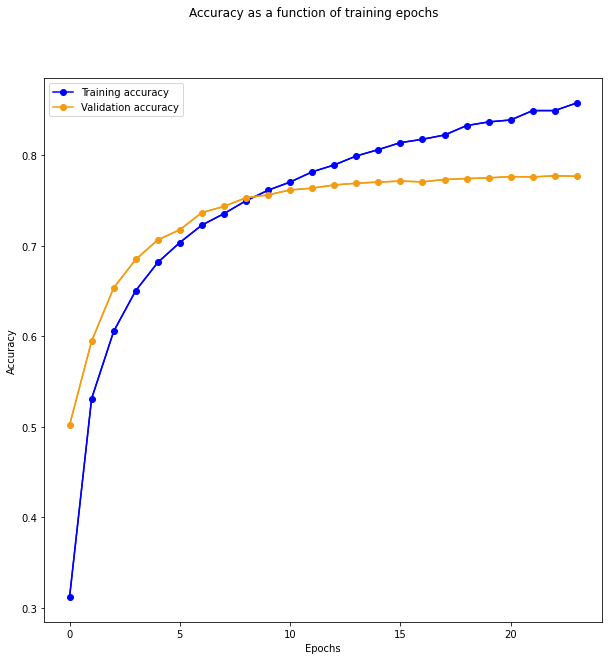

2021-10-11 10:07:56.970716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_2333/3439041799.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels_xaxes)
/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_2333/3439041799.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels_yaxes)


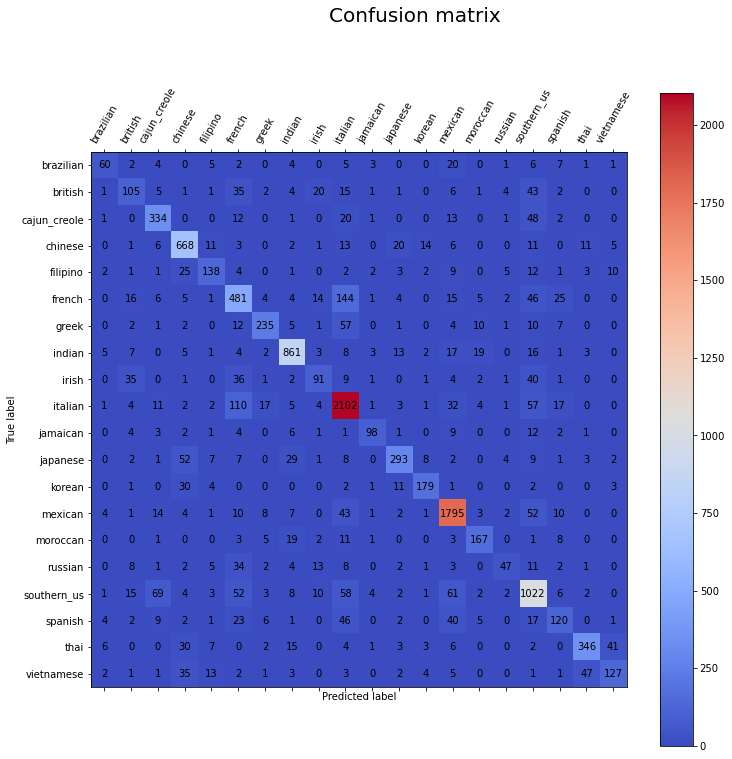

1. Accuracy = 0.7767535406016928 (i.e. 77.67535406016928 %)

2. f1_scores for each class:

           brazilian:	0.5769
             british:	0.4626
        cajun_creole:	0.7422
             chinese:	0.8136
            filipino:	0.6540
              french:	0.5986
               greek:	0.7390
              indian:	0.8826
               irish:	0.4715
             italian:	0.8522
            jamaican:	0.7424
            japanese:	0.7399
              korean:	0.7938
             mexican:	0.8955
            moroccan:	0.7608
             russian:	0.4372
         southern_us:	0.7452
             spanish:	0.4878
                thai:	0.7828
          vietnamese:	0.5799


3. avg f1_score (without considering class imbalance): 0.6879329925487654

4. avg f1_score (weighted by considering class imbalance): 0.7718724810348556

num_samples = 9944
num_ingredients = 6714
num_cuisines = 20


In [67]:
nn = NN()
nn.train(X_train, Y_train, X_test, Y_test)
nn.validate(X_test, Y_test)
nn.write_prediction('./test.json', './nn_one_hot_submission.csv', False)

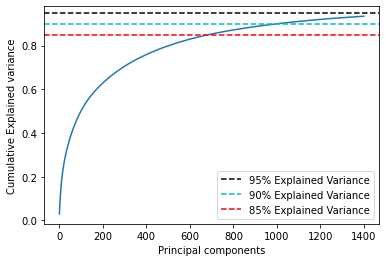

In [57]:
# PCA on the dataset
from sklearn.decomposition import PCA
## Step 3: Perform PCA against the train data set.
pca = PCA(n_components=1400).fit(X_train)
# calculate pc_700 as comparison on how much fiedelity retained
pc_700 = PCA(n_components=700).fit(X_train)
# There is an easy way to explained variance ratio curve from PCA library
# Once again after 1400 eigenvalue, the ratio is approaching 0.94
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = .95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = .90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = .85, color='r', linestyle='--', label = '85% Explained Variance')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

The above chart on cumulative sum against indexes in eigenvalue list indicates that fast decay approaching or after 1400 value which means that we can choose the highest top 1400 eigenvalues and their corresponding eigenvectors and still be able to represent most of the featires the whole dataset would represent.

In [55]:
# Find the optimal number of PCA's by giving a criteria of how much cumulative features has been retained 
# it takes only 1333 principal components to give cumulative 93% total variance ratio. interestingly, it can never get 94%
ratios = pca.explained_variance_ratio_
# iterate through all Principal components
for i in range(np.cumsum(ratios).shape[0]):
    if np.cumsum(ratios)[i] >= 0.93:
        num_pca = i + 1
        print("The optimal number of PCA's is: {}".format(num_pca))
        break
    else:
        continue

The optimal number of PCA's is: 1333


In [58]:
## Step 4: Project Training data to PCA
train_pca = pca.transform(X_train)
train_pc_700 = pc_700.transform(X_train)
# The dimension of PCA train data set reduced data from 4096 cols down to 135 cols
print(train_pca.shape)
val_pca = pca.transform(X_test)
# The dimension of PCA test data set reduced data from 4096 cols down to 135 cols
print(val_pca.shape)

(27841, 1400)
(11933, 1400)


Epoch 1/100
 17/218 [=>............................] - ETA: 1s - loss: 2.9622 - accuracy: 0.1259

2021-10-11 10:11:24.823338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


213/218 [============================>.] - ETA: 0s - loss: 2.5062 - accuracy: 0.2711

2021-10-11 10:11:26.273826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 2s 8ms/step - loss: 2.4979 - accuracy: 0.2746 - val_loss: 2.0067 - val_accuracy: 0.4519
Epoch 2/100
218/218 [==============================] - 2s 8ms/step - loss: 1.7958 - accuracy: 0.4913 - val_loss: 1.5158 - val_accuracy: 0.5554
Epoch 3/100
218/218 [==============================] - 2s 8ms/step - loss: 1.4823 - accuracy: 0.5692 - val_loss: 1.2838 - val_accuracy: 0.6194
Epoch 4/100
218/218 [==============================] - 2s 8ms/step - loss: 1.3022 - accuracy: 0.6163 - val_loss: 1.1418 - val_accuracy: 0.6605
Epoch 5/100
218/218 [==============================] - 2s 8ms/step - loss: 1.1833 - accuracy: 0.6503 - val_loss: 1.0629 - val_accuracy: 0.6789
Epoch 6/100
218/218 [==============================] - 2s 8ms/step - loss: 1.0972 - accuracy: 0.6743 - val_loss: 0.9984 - val_accuracy: 0.7069
Epoch 7/100
218/218 [==============================] - 2s 8ms/step - loss: 1.0326 - accuracy: 0.6935 - val_loss: 0.9560 - val_accuracy: 0.7116
Epoch 8/100

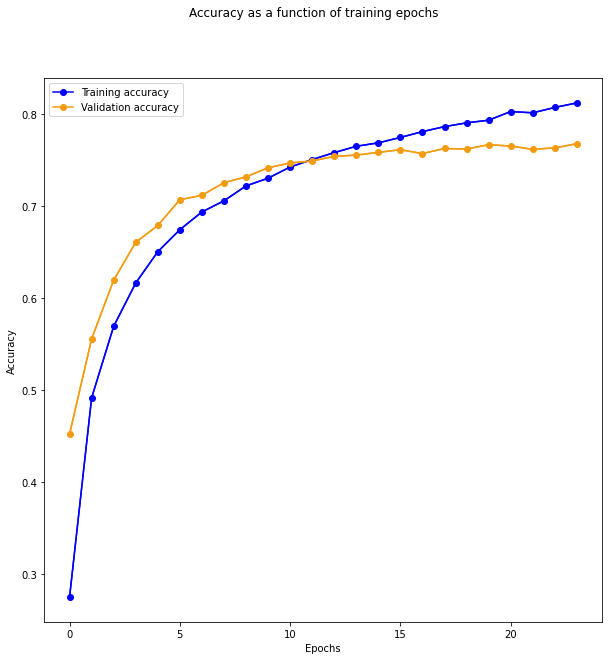

2021-10-11 10:12:05.545067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_2333/3439041799.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels_xaxes)
/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_2333/3439041799.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels_yaxes)


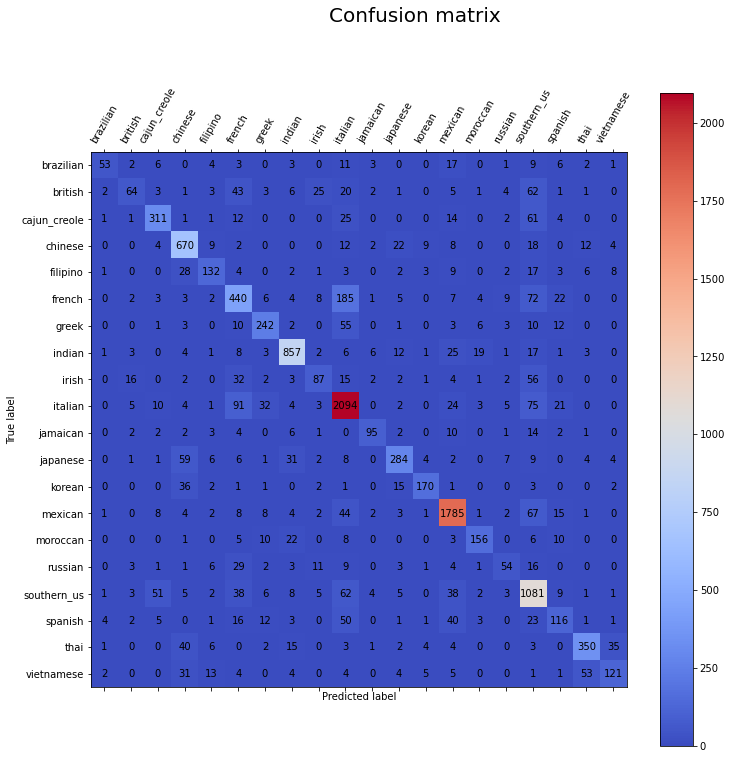

1. Accuracy = 0.7677868096874214 (i.e. 76.77868096874214 %)

2. f1_scores for each class:

           brazilian:	0.5638
             british:	0.3647
        cajun_creole:	0.7414
             chinese:	0.8038
            filipino:	0.6361
              french:	0.5755
               greek:	0.7139
              indian:	0.8803
               irish:	0.4652
             italian:	0.8394
            jamaican:	0.7224
            japanese:	0.7145
              korean:	0.7834
             mexican:	0.9002
            moroccan:	0.7464
             russian:	0.4500
         southern_us:	0.7341
             spanish:	0.4622
                thai:	0.7769
          vietnamese:	0.5694


3. avg f1_score (without considering class imbalance): 0.6721869922459124

4. avg f1_score (weighted by considering class imbalance): 0.7606605064111067

num_samples = 9944
num_ingredients = 6714
num_cuisines = 20


In [69]:
nn_pca = NN()
nn_pca.train(train_pca, Y_train, val_pca, Y_test)
nn_pca.validate(val_pca, Y_test)
nn_pca.write_prediction('./test.json', './nn_ohe_pca_submission.csv', True)

1440 principal components vs. 6714 total would cause the final best accuracy to reduce from 77.7 to 76.8, which is slight and minor. 